## Importación de dataloaders y pasos previos necesarios

In [6]:
import glob
import pickle
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator, apply_inverse
from sklearn.utils import shuffle
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Selección GPU / CPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Quadro RTX 4000


Los dataloaders utilizados 'updated_val_loader_final' y 'updated_train_loader_' son los distintos dataloaders obtenidos tras la resolución del problema inverso, los cuales se construyeron en distintos dataloaders debido al alto coste computacional de la realización de las operaciones iterando sobre cada elemento. 

In [4]:
#Definición de un Dataset personalizado para poder menejar los y construir los dataloaders
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        item = {
            'coherence_matrix': torch.tensor(self.data['coherence_matrix'][index]),
            'class_label': torch.tensor(self.data['class_label'][index]),
            'age': torch.tensor(self.data['age'][index])
        }
        return item

    def __len__(self):
        return len(self.data['coherence_matrix'])

# Unión de los distintos dataloaders de entrenamiento en uno solo
directorio_actual = './'
patron = '../dataloaders/updated_train_loader_*.pkl'
datasets = []

archivos_pkl = glob.glob(f"{directorio_actual}/{patron}")
for archivo_pkl in archivos_pkl:
    with open(archivo_pkl, 'rb') as file:
        dataloader = pickle.load(file)
        datasets.append(dataloader.dataset)

concat_dataset = ConcatDataset(datasets)
train_dataloader = DataLoader(concat_dataset, batch_size=2, shuffle=True)


# Unión de los distintos dataloaders de validación en uno solo
directorio_actual = './'
patron_val = '../dataloaders/updated_test_loader_final*.pkl'
datasets_val = []

archivos_pkl_val = glob.glob(f"{directorio_actual}/{patron_val}")
for archivo_pkl in archivos_pkl_val:
    with open(archivo_pkl, 'rb') as file:
        dataloader_ii = pickle.load(file)
        datasets_val.append(dataloader_ii.dataset)

#Unión de los distintos dataloaders en uno solo
concat_dataset = ConcatDataset(datasets_val)
val_dataloader = DataLoader(concat_dataset, batch_size=1, shuffle=False)

## SVM Coherence Matrix

### Preparación de elementos X e Y para la grid search

In [5]:

#==============================PREPARACIÓN DE LOS DATOS DE ENTRENAMIENTO=============================

reduced_matrix_train = []
class_label_train = []
age_train = []

for batch in train_dataloader:
    reduced_matrix = batch['coherence_matrix'].float().numpy()
    class_label = batch['class_label'].numpy()
    age = batch['age'].float().numpy()

    reduced_matrix_train.append(reduced_matrix)
    class_label_train.append(class_label)
    age_train.append(age)
    
reduced_matrix_train = np.concatenate(reduced_matrix_train)
class_label_train = np.concatenate(class_label_train)
age_train = np.concatenate(age_train)
age_train_expanded = np.repeat(age_train[:, np.newaxis], reduced_matrix_train.shape[1], axis=1)

inputs_train = np.concatenate((reduced_matrix_train, age_train_expanded), axis=2)
inputs_train = inputs_train.reshape(inputs_train.shape[0], -1)



#==============================PREPARACIÓN DE LOS DATOS DE VALIDACIÓN=============================

reduced_matrix_val = []
class_label_val = []
age_val = []

for batch in val_dataloader:
    reduced_matrix = batch['coherence_matrix'].float().numpy()
    class_label = batch['class_label'].numpy()
    age = batch['age'].float().numpy()

    reduced_matrix_val.append(reduced_matrix)
    class_label_val.append(class_label)
    age_val.append(age)
    
reduced_matrix_val = np.concatenate(reduced_matrix_val)
class_label_val = np.concatenate(class_label_val)
age_val = np.concatenate(age_val)
age_val_expanded = np.repeat(age_val[:, np.newaxis], reduced_matrix_val.shape[1], axis=1)

inputs_val = np.concatenate((reduced_matrix_val, age_val_expanded), axis=2)
inputs_val = inputs_val.reshape(inputs_val.shape[0], -1)

C:\Users\hernandez\AppData\Local\Temp\ipykernel_14768\4113854866.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'coherence_matrix': torch.tensor(self.data['coherence_matrix'][index]),
C:\Users\hernandez\AppData\Local\Temp\ipykernel_14768\4113854866.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'class_label': torch.tensor(self.data['class_label'][index]),
C:\Users\hernandez\AppData\Local\Temp\ipykernel_14768\4113854866.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'age': torch.tensor(self.data['age'][index])


### Grid Search

El siguietne código no hace falta ejecutarlo ya que ilustra cómo se realizó la grid_search. Esta se empezó a realizar con rangos de búsqueda de parámetros más generales y en cada etapa se fue reduciendo más este rango para acotarlo y hacerlo más preciso en base a los mejores resultados que iban surgiendo en cada etapa. Para resumir el proceso, en la siguiente celda se muestra la primera búsqueda de parámetros realizada y posteriormente se muestra la última con la que se consiguienron los mejores parámetros encontrados. Esta última celda es la que habría que ejecutar para reducir tiempos.

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

grid_search.fit(inputs_train, class_label_train)

best_params = grid_search.best_params_
print(best_params)

In [9]:
best_C = 464.15888336127773
best_gamma = 2.1544346900318865e-06

C_range_4 = np.logspace(np.log10(best_C) - 0.5, np.log10(best_C) + 0.5, 20)
gamma_range_4 = np.logspace(np.log10(best_gamma) - 0.5, np.log10(best_gamma) + 0.5, 20)
best_score = 0
best_params = {}

for C in C_range_4:
    for gamma in gamma_range_4:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(inputs_train, class_label_train)
        score = clf.score(inputs_val, class_label_val)
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}

print("Mejor puntuación encontrada:", best_score)
print("Mejores parámetros encontrados:", best_params)

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was 

Mejor puntuación encontrada: 0.5677966101694916
Mejores parámetros encontrados: {'C': 303.70793600692224, 'gamma': 2.5839297473398143e-06}


### Cálculo de métricas

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


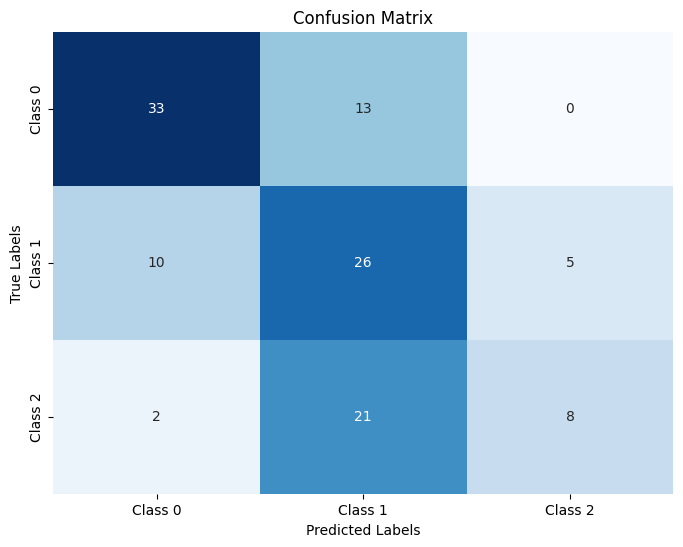

,Metric,Value
0,Accuracy,0.567797
1,Precision,0.594017
2,Recall,0.536534
3,F1 Score,0.534588


In [12]:
clf = SVC(C=best_params['C'], gamma=best_params['gamma'])
clf.fit(inputs_train, class_label_train)
val_predictions = clf.predict(inputs_val)

accuracy = metrics.accuracy_score(class_label_val, val_predictions)
precision = metrics.precision_score(class_label_val, val_predictions, average='macro')
recall = metrics.recall_score(class_label_val, val_predictions, average='macro')
f1 = metrics.f1_score(class_label_val, val_predictions, average='macro')

metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                           'Value': [accuracy, precision, recall, f1]})

confusion_matrix = metrics.confusion_matrix(class_label_val, val_predictions)
confusion_df = pd.DataFrame(confusion_matrix)

class_labels = ['Class 0', 'Class 1', 'Class 2']


# Visualización de las métricas y la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
metrics_df